In [1]:
# importing packages

import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
# activation function: sigmoid

def activation(x):
    return 1.0 / (1.0 + np.exp(-x))

In [3]:
# derivative of the activation function

def dactivation(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

In [4]:
# creating an MLP class

class MLP:
    
    def __init__(self, *args):
        """
        initializing the network with respect to the args \the given sizes\
        """
        # random seed
        np.random.seed(123)
        # the shape of the network (the number of layers)
        self.shape = args
        n = len(args)
        # creating the layers
        self.layers = []
        # creating the first, input layer (+1 unit for BIAS)
        self.layers.append(np.ones(self.shape[0]+1))
        # creating the hidden layers and the last, output layer
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # creating matrix of weights
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw includes the last modifications of the weights
        self.dw = [0,]*len(self.weights)
        # we are storing a reference for the standardization
        self.scaler = None
        # reinitializing weights
        self.reset()
    
    def reset(self):
        """
        reinitializing weights with uniform [-1,1)
        """
        for i in range(len(self.weights)):
            # random numbers from [0,1)
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # scaling weights into [-1,1)
            self.weights[i][...] = (2*Z-1)*1

    def propagate_forward(self, data):
        """
        propagating input data forward 
        """
        # first layer
        self.layers[0][0:-1] = data
        # forwarding data to the last layer
        for i in range(1,len(self.shape)):
            s_i = np.dot(self.layers[i-1], self.weights[i-1])
            self.layers[i][...] = activation(s_i)
        # returning the estimated result
        return self.layers[-1]

    def propagate_backward(self, target, lrate=0.1):
        """
        Hibavisszaterjesztés (backpropagation) definiálása. 
        Args:
            target: címkék, a kimenetek elvárt értékei
            lrate: 
                A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
                mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
                "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
                akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy 
                lokális minimumban és sose éri el azt. Defaults to 0.1.

        Returns: az aktuális kimenetek és elvárt értékek alapján számított (négyzetes) hiba
        """
        deltas = []
        # error: 1/2 (y-y_tilde)**2
        # derivative of error on last layer: (dC/dy_tilde)
        derror = -(target-self.layers[-1]) # y-y_tilde
        # error*dactivation(s(3))
        s_last = np.dot(self.layers[-2],self.weights[-1])
        delta_last = derror * dactivation(s_last)
        deltas.append(delta_last)
        # calculating gradients on hidden layer(s)
        for i in range(len(self.shape)-2,0,-1):
            s_i = np.dot(self.layers[i-1],self.weights[i-1])

            delta_i = np.dot(deltas[0],self.weights[i].T)*dactivation(s_i)

            deltas.insert(0,delta_i)
            
        #up to this point everything is the same as in the practice notebook
        
        # calculating difference of weights
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])

            dw = -lrate*np.dot(layer.T,delta)

            self.dw[i] = dw
            #here we do not change weights

        # returning error
        error = (target-self.layers[-1])**2 
        return error.sum()
    
    #these functions are mine, pretty straighforward what they do
    def updating_weights(self, dws, batch_size=32):
        #updating weights with dws - difference of weights
        for l in range(len(self.weights)):
            # dividing by batch_size because we need average of gradients (not the sum)
            dws[l]/=batch_size
            self.weights[l] += dws[l]
            
    def returning_self_weights(self):
        return self.weights
    
    def returning_self_dw(self):
        return self.dw

In [5]:
from sklearn import preprocessing
def learn(network, X, Y, valid_split, test_split, batch_size=32, epochs=20, lrate=0.1):

    # selecting train-validation-test samples 
    nb_samples = len(Y)
    X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
    Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
    X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
    Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
    X_test  = X[int(nb_samples*(1-test_split)):]
    Y_test  = Y[int(nb_samples*(1-test_split)):]

    # standardization
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)
    network.scaler = scaler

    # shuffling train samples
    randperm = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[randperm], Y_train[randperm]
    
    #the difference between this notebook and the notebook of second practice is here
    
    # training phase, we go through every batch in every epoch
    for i in range(epochs):
        no_of_batches = X_train.shape[0] // batch_size
        # training error during an epoch
        train_err_all=0
        for j in range(no_of_batches):
            # training error during a batch
            train_err = 0
            # difference of the weights
            dws=np.zeros_like(network.returning_self_weights())
            # we go through every sample of the batch
            for k in range(j*batch_size,(j+1)*batch_size):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
                # adding difference of weights of every sample to the whole difference of weights
                for l in range(len(network.returning_self_weights())):
                    dws[l] += network.returning_self_dw()[l]
            network.updating_weights(dws, batch_size)
            train_err /= batch_size
            train_err_all += train_err
        train_err_all /= no_of_batches

        # validation phase
        valid_err = 0
        o_valid = np.zeros(X_valid.shape[0])
        for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward(X_valid[k])
            valid_err += (o_valid[k]-Y_valid[k])**2
        valid_err /= X_valid.shape[0]

        print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err_all, valid_err))
    
    # from here it's the same as in the notebook of practice

    # test phase
    print("\n--- TESTING ---\n")
    test_err = 0
    o_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        o_test[k] = network.propagate_forward(X_test[k])
        test_err += (o_test[k]-Y_test[k])**2
        print(k, X_test[k], '%.2f' % o_test[k], ' (expected result: %.2f)' % Y_test[k])
    test_err /= X_test.shape[0]
    
    plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.coolwarm)

In [6]:
network = MLP(2,10,1)

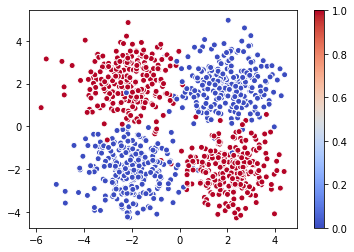

In [7]:
#this is the same as in the second notebook of practice

# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
def get_2d_normal(nb_samples, loc=[0,0], scale=1.0, label=0, X=None, Y=None):
        """ 
        2D normál eloszlás mintavételezésével generál pontokat a megadott középpont körül és állít elő címkéket tartalmazó tömböt hozzájuk.
        Ha X, Y-ban megadunk egy "adathalmazt" mely tartalmaz már pontokat, a generált pontokat konkatenálja a meglévőkhöz.
        """
        X_new = np.random.normal(loc, scale, (nb_samples, 2))
        Y_new = np.repeat(label, nb_samples)
        if X is not None and Y is not None:
            X_new = np.concatenate([X, X_new], axis=0)
            Y_new = np.concatenate([Y, Y_new], axis=0)
        return X_new, Y_new


def get_dataset(nb_samples=1000):
    X, Y = get_2d_normal(nb_samples//4, [2, 2],   label=0)
    X, Y = get_2d_normal(nb_samples//4, [-2, -2], label=0, X=X, Y=Y)
    X, Y = get_2d_normal(nb_samples//4, [2, -2],  label=1, X=X, Y=Y)
    X, Y = get_2d_normal(nb_samples//4, [-2, 2],  label=1, X=X, Y=Y)

    randperm = np.random.permutation(len(X))
    X, Y = X[randperm], Y[randperm]
    return X, Y

# Alternatív kód az adatok generálására
# def get_dataset(nb_samples=1000):
#     X = np.zeros((nb_samples,2))
#     Y = np.zeros(nb_samples)
#     for i in range(0,nb_samples,4):
#         noise = np.random.normal(0,1,8)
#         X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
#         X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
#         X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
#         X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

X,Y = get_dataset()

plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.coolwarm, linewidth=1, edgecolors='w', vmin=0, vmax=1)
plt.colorbar();

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0 epoch, train_err: 0.2581, valid_err: 0.2536
1 epoch, train_err: 0.2548, valid_err: 0.2511
2 epoch, train_err: 0.2521, valid_err: 0.2489
3 epoch, train_err: 0.2497, valid_err: 0.2468
4 epoch, train_err: 0.2473, valid_err: 0.2447
5 epoch, train_err: 0.2450, valid_err: 0.2426
6 epoch, train_err: 0.2424, valid_err: 0.2402
7 epoch, train_err: 0.2397, valid_err: 0.2375
8 epoch, train_err: 0.2366, valid_err: 0.2345
9 epoch, train_err: 0.2331, valid_err: 0.2310
10 epoch, train_err: 0.2292, valid_err: 0.2270
11 epoch, train_err: 0.2246, valid_err: 0.2223
12 epoch, train_err: 0.2194, valid_err: 0.2171
13 epoch, train_err: 0.2134, valid_err: 0.2111
14 epoch, train_err: 0.2068, valid_err: 0.2044
15 epoch, train_err: 0.1996, valid_err: 0.1971
16 epoch, train_err: 0.1917, valid_err: 0.1893
17 epoch, train_err: 0.1834, valid_err: 0.1810
18 epoch, train_err: 0.1747, valid_err: 0.1725
19 epoch, train_err: 0.1660, valid_err: 0.1639
20 epoch, train_err: 0.1572, valid_err: 0.1555
21 epoch, train_err: 0.

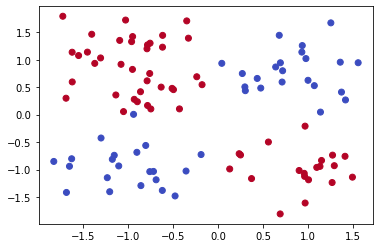

In [8]:
# Starting training/testing

network.reset()
valid_split = 0.2; test_split = 0.1
learn(network, X, Y, valid_split, test_split, batch_size=4, epochs=100)